# Temperature scaling
Based on paper [On Calibration of Modern Neural networks](https://arxiv.org/abs/1706.04599)

In [1]:
%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from typing import List, Tuple
from tqdm import tqdm

In [3]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model

Load the dataset used to train model

In [4]:
((X_train, y_train), (X_test, y_test)) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [5]:
labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

Load the TensorFlow SavedModel

In [6]:
model = tf.keras.models.load_model("../models/model_DC274/")

Create a probability model by adding a final Softmax layer

In [7]:
prob_model = tf.keras.models.Sequential([model, tf.keras.layers.Softmax()])

In [8]:
y_probs = prob_model.predict(X_test)

In [9]:
def calc_predictions(y_probs: pd.DataFrame, labels: List[str]) -> pd.DataFrame:
    """
    Calculates the predictions from the probability model output, and assigns
    labels to all columns based on the labels
    """
    y_preds = pd.DataFrame(y_probs, columns=labels)
    labels_to_idx = {i: x for i, x in enumerate(labels)}
    y_preds["prediction"] = y_preds.idxmax(axis=1)
    y_preds["confidence"] = y_preds.apply(lambda x: x[x["prediction"]], axis=1)
    y_preds["category"] = np.argmax(y_test, axis=1)
    y_preds["category"] = y_preds.category.apply(lambda x: labels_to_idx[x])
    return y_preds

In [10]:
y_preds = calc_predictions(y_probs, labels)

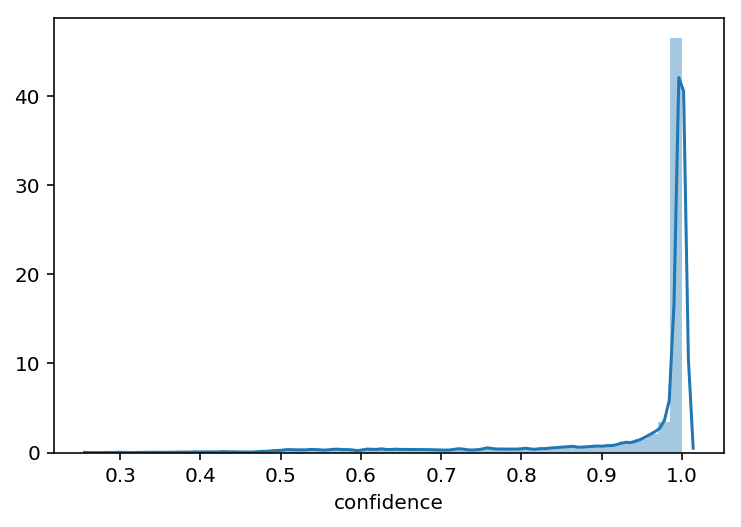

In [11]:
sns.distplot(y_preds.confidence)

In [12]:
def get_view(
    data: pd.DataFrame, interval: Tuple[int], probability_col: str = "confidence"
) -> pd.DataFrame:
    """Retrieves data within the interval specified"""
    return data[data[probability_col].between(*interval)]


def accuracy_of_interval(
    data: pd.DataFrame,
    category_col: str = "category",
    prediction_col: str = "prediction",
) -> float:
    """Calculates the accuracy of the model predictions"""
    return accuracy_score(data[category_col], data[prediction_col])


def confidence_of_interval(
    data: pd.DataFrame,
    category_col: str = "category",
    probability_col: str = "confidence",
) -> float:
    """Calculates the average confidence of the model predictions"""
    return data[probability_col].sum() / data.shape[0]

In [13]:
def expected_calibration_error(
    data: pd.DataFrame,
    probability_col: str = "confidence",
    category_col: str = "category",
    prediction_col: str = "prediction",
) -> float:
    """Calculates the expected calibration error of the model"""
    intervals = np.linspace(0, 1, 11)
    ece = 0
    for i in range(len(intervals) - 1):
        interval = (intervals[i], intervals[i + 1])
        view = get_view(data, interval, probability_col=probability_col)
        acc = accuracy_of_interval(
            view, category_col=category_col, prediction_col=prediction_col
        )
        conf = confidence_of_interval(view, probability_col=probability_col)
        if np.isnan(acc):
            acc = 0
        if np.isnan(conf):
            conf = 0
        a = view.shape[0] / data.shape[0]
        b = math.fabs(acc - conf)
        ece += a * b
    return ece

In [14]:
expected_calibration_error(y_preds) * 100

1.1547112420201282

In [15]:
def plot_reliability_diagram(y_preds: pd.DataFrame):
    """
    Plots a reliability diagram using the predictions from the model
    """
    intervals = np.linspace(0, 1, 11)
    bins = []
    for i in range(len(intervals) - 1):
        interval = (intervals[i], intervals[i + 1])
        view = y_preds[y_preds.confidence.between(*interval)]
        acc = accuracy_score(view.category, view.prediction)
        if np.isnan(acc):
            acc = 0
        bins.append([interval, acc])

    f, ax = plt.subplots(1, figsize=(10, 10))
    bars = ax.bar(
        [b[0][0] for b in bins],
        [b[0][1] for b in bins],
        width=0.1,
        align="edge",
        linewidth=1,
        edgecolor="red",
        color="red",
        alpha=0.1,
    )
    bars = ax.bar(
        [b[0][0] for b in bins],
        [b[1] for b in bins],
        width=0.1,
        align="edge",
        linewidth=1,
        edgecolor="black",
        color="teal",
    )
    ax.set_xlim([0, 1])
    ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1))
    ax.plot(
        np.linspace(0, 1, 11),
        np.linspace(0, 1, 11),
        color="red",
        linewidth=2,
        linestyle="--",
    )
    ax.set_ylim([0, 1])
    ax.set_xlabel("Confidence")
    ax.set_ylabel("Accuracy")

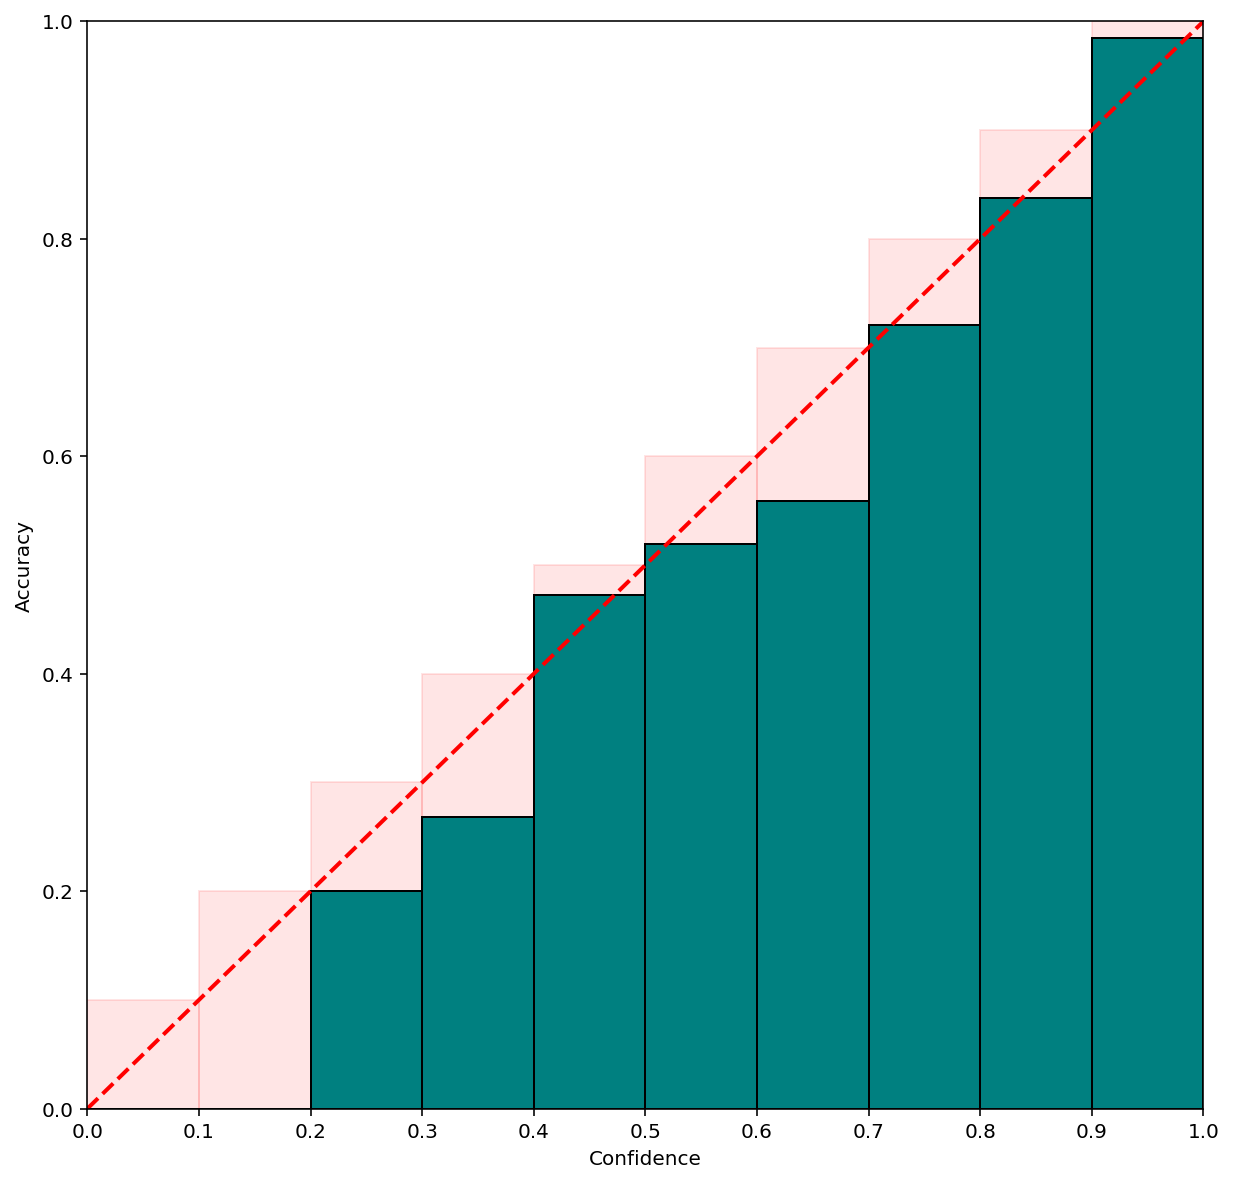

In [16]:
plot_reliability_diagram(y_preds)

In [17]:
def softmax(logits: tf.Tensor, temperature: int = 1):
    logits = logits / temperature
    return tf.exp(logits) / tf.reshape(tf.reduce_sum(tf.exp(logits), axis=1), (-1, 1))

# Using gradient descent to optimise the temperature value (temperature scaling)

Custom sequential model to support setting a temperature value for the softmax layer once the correct value is found:

In [18]:
class TemperatureScaledSoftMax(tf.keras.layers.Layer):
    def __init__(self, temperature: float = 1):
        super(TemperatureScaledSoftMax, self).__init__()
        self.temperature = temperature

    def call(self, logits: tf.Tensor, train: bool = False):
        return softmax(logits, temperature=self.temperature)

Temperature scaling should be done using the logits from the logits produced from the model using a validation dataset:

In [19]:
validation_logits = model.predict(X_test)

In [20]:
N_EPOCHS = 5

Building a TensorFlow dataset to use batching, shuffling, etc.

In [21]:
data = tf.data.Dataset.from_tensor_slices((validation_logits, y_test)).repeat(N_EPOCHS)

A custom TensorFlow model to use in a custom training loop, that includes the temperature as a trainable variable

In [22]:
class SoftmaxTemperature(Model):
    def __init__(self):
        super().__init__()
        self.temperature = tf.Variable(1.0)

    def call(self, x: tf.Tensor):
        return softmax(x, temperature=self.temperature)

In [23]:
temp_model = SoftmaxTemperature()

In [24]:
def loss(y: tf.Tensor, pred: tf.Tensor):
    """Loss function"""
    return tf.nn.softmax_cross_entropy_with_logits(y, pred)


optimiser = tf.optimizers.RMSprop(learning_rate=1e-5)


def train(model: Model, x: tf.Tensor, y: tf.Tensor):
    with tf.GradientTape() as tape:
        predictions = model(x)
        _loss = loss(y, predictions)
    gradients = tape.gradient(_loss, [model.temperature])
    # Raises `tf.errors.InvalidArgumentError` if NaN values found
    tf.debugging.check_numerics(gradients, "Gradient value is NaN")
    optimiser.apply_gradients(zip(gradients, model.trainable_variables))

In [25]:
for epoch in tqdm(range(N_EPOCHS)):
    for _x, _y in data.shuffle(X_test.shape[0]).batch(32):
        try:
            train(temp_model, _x, _y)
        except tf.errors.InvalidArgumentError:
            break

100%|██████████| 5/5 [00:27<00:00,  5.42s/it]


In [27]:
temp_model.temperature.numpy()

0.92884994

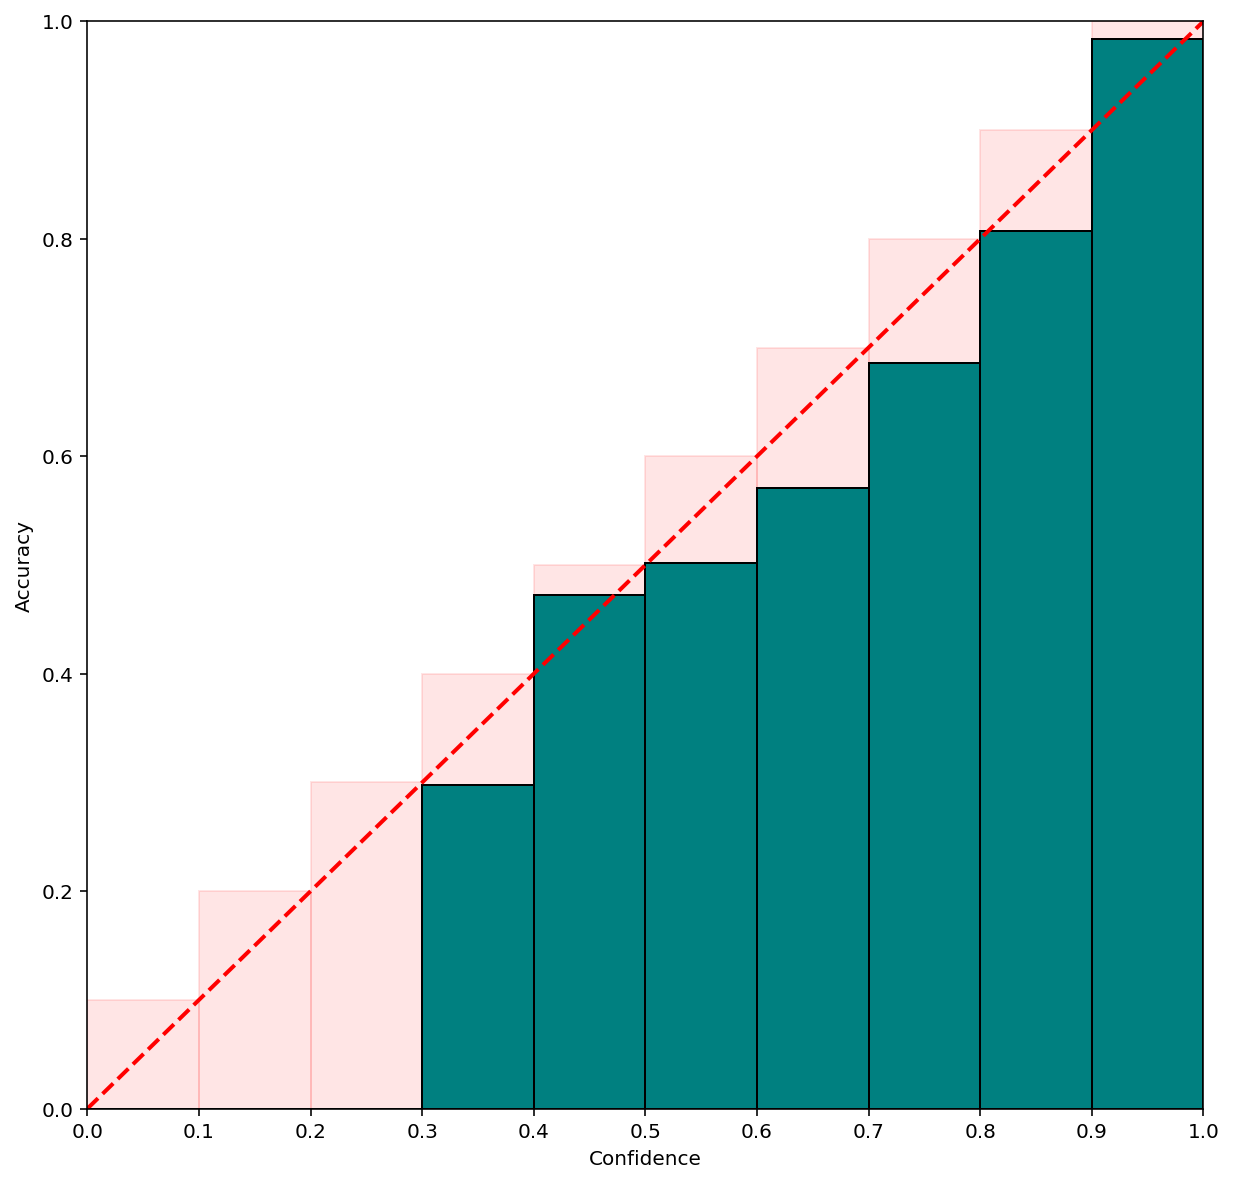

In [28]:
calibrated_model = tf.keras.models.Sequential(
    [model, TemperatureScaledSoftMax(temperature=temp_model.temperature.numpy())]
)
y_probs = calibrated_model.predict(X_test)
y_preds = calc_predictions(y_probs, labels)

plot_reliability_diagram(y_preds)

In [29]:
expected_calibration_error(y_preds) * 100

1.6361812224984105